In [26]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''):
        ## Initializing a value object
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        ## Gives the data of the value object in a formatted string
        return f"Value(data={self.data})"

    def __add__(self, other):
        ## Addition operation and the partial derivatives for the inputs
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        ## Enables the addition when this object is on the right.
        return self + other

    def __mul__(self, other):
        ## Multiplication operation and the partial derivatives for the inputs
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        ## Power operation and the partial derivatives for the inputs
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other , (self, ), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self,other):
        ## Enables the multiplication when this object is on the right.
        return self*other

    def __truediv__(self,other):
        ## True division operation
        return self*other**-1

    def __neg__(self):
        ## Negative of a value
        return self*-1

    def __sub__(self,other):
        ## Subtraction operation
        return self + (-other)

    def tanh(self):
        ## tanh operation and the partial derivatives for the inputs
        t = self.data
        out = Value((math.exp(2*t)-1)/(math.exp(2*t)+1), (self,), 'tanh')

        def _backward():
            self.grad += (1-out.data**2)*out.grad
        out._backward = _backward
        
        return out

    def relu(self):
        ## Rectified Linear Unit operation and the partial derivatives for the inputs
        output = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')

    def _backward():
        self.grad += (output.data > 0) * output.grad
        output._backward = _backward

        return output

    def exp(self):
        ## Exponent operation and the partial derivatives for the inputs
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward

        return out

    def backward (self):
        ## Definition of backward pass
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [150]:
from graphviz import Digraph

def trace(root):
    ## builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    ## Draws the values and gradients of the entire neural network
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        ## for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        ## connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [151]:
import torch

In [152]:
class Neuron:

  def __init__(self, num_input):
    ## Initializing the Neuron
    #< @param x A list of input values.
    #< @return The output of the neuron.
    self.w = [Value(random.uniform(-1, 1)) for _ in range(num_input)]  
    self.b = Value(random.uniform(-1, 1)) 

  def __call__(self, x):
    ## Gives the output of the neuron.
    #< @param x A list of input values.
    #< @return The output of the neuron.
    activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  
    return activation.tanh() 

  def parameters(self):
    ## Returns the parameters of the neuron.
    #< @return Gives a list of neuron's weights and biases.
    return self.w + [self.b]

class Layer:

  def __init__(self, num_input, num_output):
    ## Initializing the layer.
    #< @param num_input Number of inputs accepted by a neuron.
    #< @param num_output Number of neurons.
    self.neurons = [Neuron(num_input) for _ in range(num_output)] 

  def __call__(self, x):
    ## Gives the output of the layer.
    #< @param x A list of input values for the layer.
    #< @return The output of the layer, either as a single value or a list of values.
    outputs = [n(x) for n in self.neurons] 
    return outputs[0] if len(outputs) == 1 else outputs  

  def parameters(self):
    ## Returns the parameters of all neurons in the layer.
    #< @return A list of the parameters of the layer's neurons.
    return [p for n in self.neurons for p in n.parameters()]  

class MLP:

  def __init__(self, num_input, num_outputs):
    ## Initializing the MLP.
    #< @param num_input Number of inputs and outputs.
    #< @param num_outputs List of all the sizes of outputs.
    size = [num_input] + num_outputs  # Construct the size list for all layers
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(num_outputs))] 

  def __call__(self, x):
    ## Computes the output of the MLP for a given input.
    #< @param x A list of input values for the MLP.
    #< @return The output of the MLP after passing through all layers.
    for layer in self.layers:
        x = layer(x)  
    return x  

  def parameters(self):
    ## Returns the parameters of all layers in the MLP.
    #< @return A list of parameters from all layers.
    return [p for l in self.layers for p in l.parameters()] 


In [173]:
xs = [[2], [3], [4]]
ys = [2, 1, -2]

n = MLP(1, [4,4,1])

In [174]:
epoch_instances = 300
LR = 0.02
loss_data, weight_data, bias_data = [], [], []

for epoch_instance in range(epoch_instances):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # Store data for plotting
  loss_data.append(loss.data)
  weight_data.append(n.layers[0].neurons[0].w[0].data)
  bias_data.append(n.layers[0].neurons[0].b.data)
    
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update
  for p in n.parameters():
    # Using the constant learning rate defined above
    p.data += -LR * p.grad

print(ypred)

[Value(data=0.9927262895273702), Value(data=0.9374724857568795), Value(data=-0.9874565133552508)]


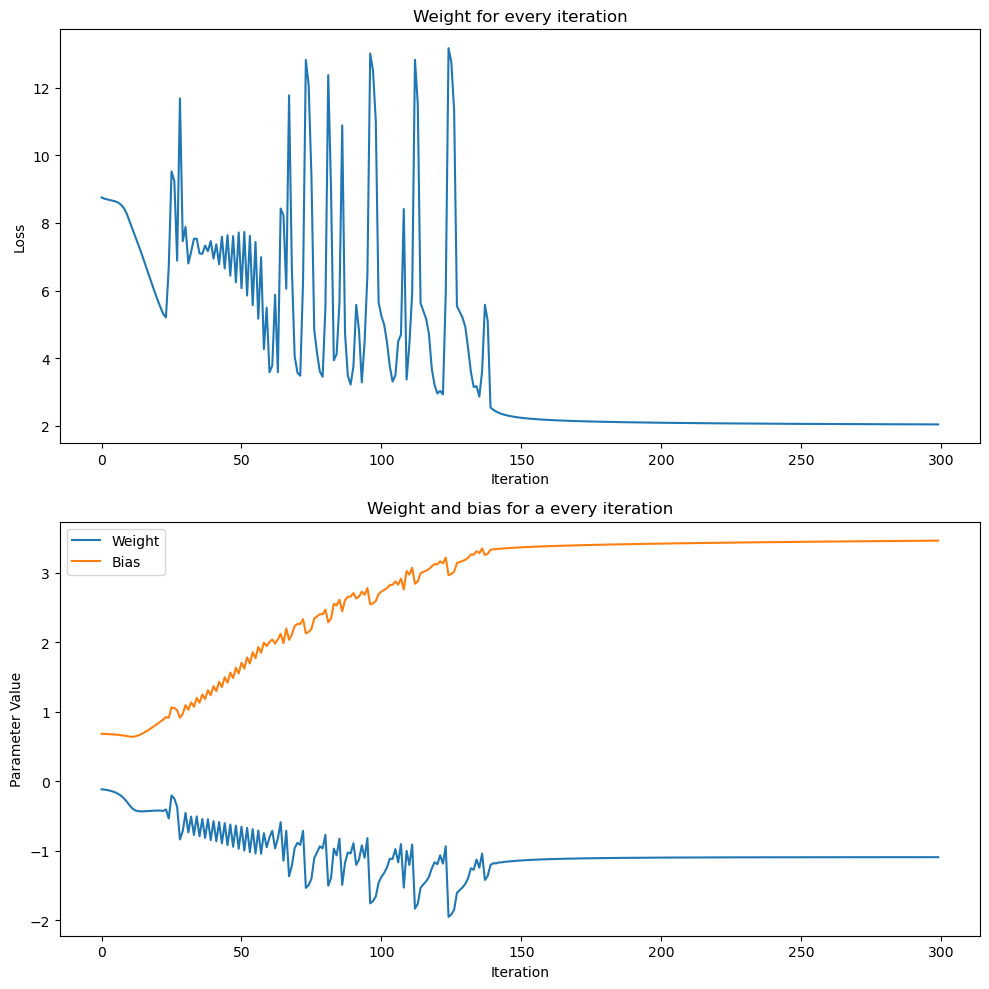

In [175]:
iterations = list(range(epoch_instances))
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(iterations, loss_data)
axs[0].set_title('Weight for every iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')

axs[1].plot(iterations, weight_data, label='Weight')
axs[1].plot(iterations, bias_data, label='Bias')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Parameter Value')
axs[1].set_title('Weight and bias for a every iteration')
axs[1].legend()

plt.tight_layout()
plt.show()

In [176]:
epoch_instances = 300
LR = 0.1
loss_data, weight_data, bias_data = [], [], []

for epoch_instance in range(epoch_instances):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # Store data for plotting
  loss_data.append(loss.data)
  weight_data.append(n.layers[0].neurons[0].w[0].data)
  bias_data.append(n.layers[0].neurons[0].b.data)
    
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update
  for p in n.parameters():
    # Using the constant learning rate defined above
    p.data += -LR * p.grad

print(ypred)

[Value(data=0.999158571791021), Value(data=0.9831672858809485), Value(data=-0.9987857944303257)]


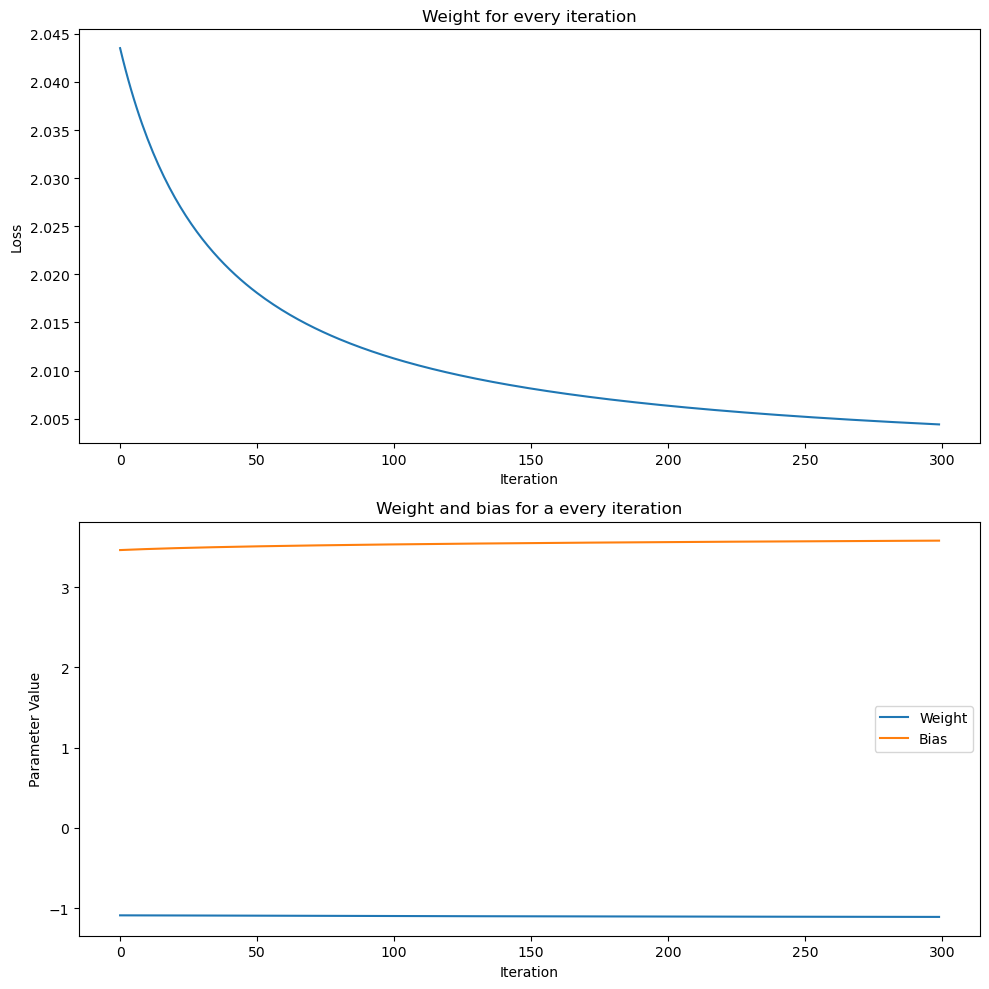

In [177]:
iterations = list(range(epoch_instances))
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(iterations, loss_data)
axs[0].set_title('Weight for every iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')

axs[1].plot(iterations, weight_data, label='Weight')
axs[1].plot(iterations, bias_data, label='Bias')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Parameter Value')
axs[1].set_title('Weight and bias for a every iteration')
axs[1].legend()

plt.tight_layout()
plt.show()